0. Set Up

In [1]:

!git clone --branch feature/002-rotation https://github.com/antonfrancois/Demeter_metamorphosis.git

fatal: destination path 'Demeter_metamorphosis' already exists and is not an empty directory.


Install packages

In [2]:
import subprocess
import sys, os

cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

!pip install pynrrd
!pip install -U ipywidgets
print("\nInstalation of demeter from pip")
!pip install -e .
# !pip install -e .

repo_path = os.path.abspath('.')
# repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)


/content/Demeter_metamorphosis

Instalation of demeter from pip
Obtaining file:///content/Demeter_metamorphosis
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for demeter_metamorphosis (pyproject.toml) ... done
  Created wheel for demeter_metamorphosis: filename=demeter_metamorphosis-0.2.11-0.editable-py3-none-any.whl size=4322 sha256=b0df35d0723e05d5f85f4e34b626ee0de115e884864628a4d47d554e8fba11d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8dknua7/wheels/c7/71/aa/4dfac81c8e26328effd94ced03987bdc69e149508d2e247f6c
Successfully built demeter_metamorphosis
  Attempting uninstall: demeter_metamorphosis
    Found existing installation: demeter_metamorphosis 0.2.11
    Uninstalling demeter_metamorphosis-0.2.11:
      Successfully uninstalled demeter_metamorphosis-0.2.11
['/content/Demeter_metamorphosis', 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# from google.colab import output
# output.enable_custom_widget_manager()

## 0.2 After jupyter restart, run:

In [15]:
# %matplotlib widget

import sys
import os


# Remplace par le chemin relatif où se trouve le package 'demeter'
# Exemple : si ton notebook est dans le dossier root du repo, et demeter est un sous-dossier
import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()
if not "Demeter" in cwd:
	%cd Demeter_metamorphosis/

# repo_path = os.path.abspath('.')
repo_path = "/content/Demeter_metamorphosis/"
if repo_path not in sys.path:
	sys.path.insert(0, repo_path)
print(sys.path)



['/content/Demeter_metamorphosis/', '/content/Demeter_metamorphosis', '/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/content/Demeter_metamorphosis/src', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/tmp/tmpu21_cuwj']


# 1. Code utile

In [1]:
import os
import nibabel as nib
import numpy as np
import torch
from torch.cuda import OutOfMemoryError

import demeter.utils.torchbox as tb
import demeter.utils.axes3dsliders_plt as a3s
import demeter.utils.rigid_exploration as rg
## Faire Recalage Rigid + Meta
import demeter.utils.reproducing_kernels as rk
import matplotlib.pyplot as plt

# %load_ext autoreload
# %autoreload 2
import demeter.metamorphosis as mt
import demeter.metamorphosis.rotate as mtrt

def to_torch(img):
    return torch.from_numpy(img)[None, None]

def normalize(img):
    quant = np.quantile(img, 0.99)
    print(quant, img.max())
    img = np.clip(img, 0,quant)
    img /= img.max()
    return img

import subprocess
cwd = subprocess.check_output("pwd", text=True).strip()

🔍 Vérification de l'environnement Matplotlib interactif...
✅ ipympl est installé.
✅ `%matplotlib widget` activé avec succès.
✅ Backend interactif actif : widget
🎉 Environnement prêt pour les mises à jour dynamiques avec `.set_data()` et sliders interactifs !
saves_overview.csv


## Open images

template : (193, 229, 193)
ixi_img : (192, 256, 256)
ixi_segs : (192, 256, 256)
89.21373212197796 97.66312555782497
109.0 155.0
torch.Size([1, 1, 57, 68, 57])


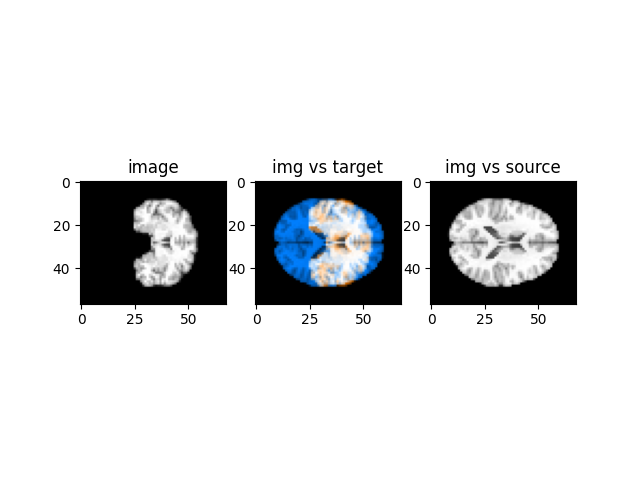

torch.float64


In [2]:
# Open template
if "content" in cwd:
  template_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
  ixi_folder = "/content/drive/MyDrive/demeter_data/ixi-T1/"
else:
  template_folder ="/home/turtlefox/Documents/11_metamorphoses/data/templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c"
  ixi_folder = "/home/turtlefox/Documents/11_metamorphoses/data/IXI-T1_fastsurfer/IXI002/mri/"

template_name = "mni_icbm152_t1_tal_nlin_asym_09c.nii"
template_mask_name = "mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"

template = nib.load(os.path.join(template_folder, template_name)).get_fdata()
template_mask = nib.load(os.path.join(template_folder, template_mask_name)).get_fdata()
template[template_mask == 0] = 0
# TODO : Open segs

print("template :",template.shape)

# Open ixi image

# ixi_list = os.listdir(ixi_folder)
ixi_image_name = "orig_nu.mgz"
# ixi_image_name = "firt_toMNI_orig_nu.nii.gz"
ixi_segs_name = "aseg.auto_noCCseg.mgz"
ixi_mask_name = "mask.mgz"
# ixi_mask_name = "firt_toMNI_orig_nu_mask.nii.gz"

ixi_img = nib.load(os.path.join(ixi_folder, ixi_image_name)).get_fdata()
ixi_segs = nib.load(os.path.join(ixi_folder, ixi_segs_name)).get_fdata()
ixi_mask = nib.load(os.path.join(ixi_folder, ixi_mask_name)).get_fdata()
ixi_img[ixi_mask == 0] = 0

print("ixi_img :",ixi_img.shape)
print("ixi_segs :",ixi_segs.shape)
name = "IXI002_to_template"


# Normalise images to [0,1]
template = normalize(template)
ixi_img = normalize(ixi_img)

#  Resize ixi image
template = to_torch(template)
template = tb.resize_image(template, scale_factor= .7)
ixi_img = to_torch(ixi_img)
ixi_img = tb.resize_image(ixi_img, to_shape=template.shape[2:])

print(ixi_img.shape)

img = ixi_img[0,0,..., ixi_img.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(ixi_img[..., ixi_img.shape[-1]//2].detach().cpu(), template[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = template[..., ixi_img.shape[-1]//2].detach().cpu()[0,0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
plt.show()

print(img.dtype)

## Recherche rigide


In [3]:
# Recherche rigide
source_b, target_b, trans_s, trans_t = rg.align_barycentres(ixi_img, template, verbose=True)

kernelOperator = rk.GaussianRKHS(sigma=(15,15,15),normalized=False)
# datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=1)
datacost = mt.Rotation_MutualInformation_Cost(target_b.to('cuda:0'), alpha=1)


mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=0,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
)
top_params = rg.initial_exploration(mr,r_step=10, max_output = 15, verbose=True)
print(top_params)

S compute barycentre : tensor([0.2111, 0.1290, 0.0069], dtype=torch.float64)
T compute barycentre : tensor([-0.0858, -0.0352, -0.0024], dtype=torch.float64)
diff :  tensor([-0.2969, -0.1642, -0.0093], dtype=torch.float64)
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 1.69 MB | Max Reserved: 20.00 MB
Init search : 1 / 50
dict_keys(['momentum_R', 'momentum_S'])


/home/turtlefox/Documents/11_metamorphoses/Demeter_metamorphosis/src/demeter/metamorphosis/rotate.py:295: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4413.)
  momT_translated = momentum_T @ translation.T


	 (tensor(6292.8254, dtype=torch.float64), tensor([-3.1416,  0.0000,  0.0000]))
Init search : 2 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6213.5331, dtype=torch.float64), tensor([-3.1416,  0.7854,  0.0000]))
Init search : 3 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6245.8428, dtype=torch.float64), tensor([-3.1416,  1.5708,  0.0000]))
Init search : 4 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6845.0681, dtype=torch.float64), tensor([-3.1416,  2.3562,  0.0000]))
Init search : 5 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6920.6984, dtype=torch.float64), tensor([-3.1416,  3.1416,  0.0000]))
Init search : 6 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6990.9771, dtype=torch.float64), tensor([-2.4435,  0.0000,  0.0000]))
Init search : 7 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(6846.7459, dtype=torch.float64), tensor([-2.4435,  0.7854,  0.0000]))
Init search : 8 / 50
dict_keys(['momentum_R', 'momentum_S'])
	 (tensor(653

In [4]:
best_loss, best_momentum_R, best_momentum_T, best_rot = rg.optimize_on_rigid(mr, top_params, n_iter=10,verbose=True)
 

>>>>>>>>>>
0/15 Optimize wit params [-1.0471975803375244, 0.0, 0.0]
momenta type <class 'dict'>
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.dtype: torch.float32
mp.image dtype:  torch.float64
rotated_image.d

In [9]:
# source_b, target_b, trans_s, trans_t = rg.align_barycentres(ixi_img, template, verbose=True)
# best_momentum_R = torch. tensor([[ 0.0000,  3.3578, -0.1457],
#         [-3.3578,  0.0000, -0.0668],
#         [ 0.1457,  0.0668,  0.0000]])
# best_momentum_T = torch. tensor([ 0.0209, -0.0455,  0.0018])

## Check rigid search

tensor([[-6.4163e-04,  7.0414e-03, -2.4325e-02],
        [-6.9822e-03, -5.0673e-05,  1.3879e-03],
        [ 2.4342e-02, -1.0465e-03, -5.9393e-04]], requires_grad=True)
tensor([-0.4022,  0.0984,  0.0459], requires_grad=True)
[Tensor.rigid_along_metamorphosis] 
	Max Allocated: 284.49 MB | Max Reserved: 1062.00 MB
tensor([[ 0.9997,  0.0070, -0.0243],
        [-0.0070,  1.0000,  0.0013],
        [ 0.0243, -0.0011,  0.9997]], grad_fn=<MmBackward0>)


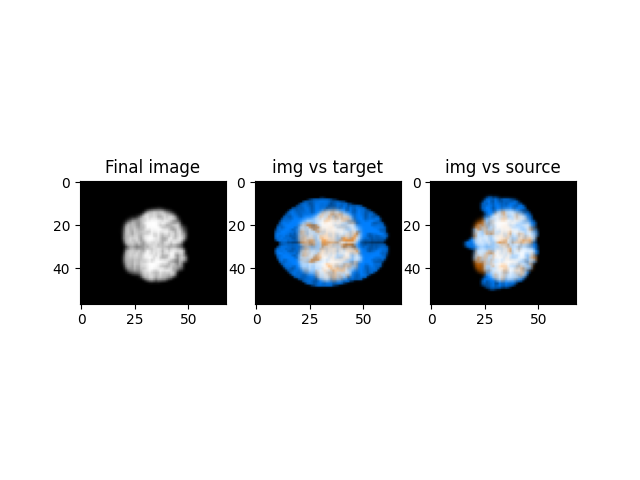

In [5]:
momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    source_b.shape,
    image=False,
    rotation=True,
    translation=True,
    rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),# - trans_s + trans_t,
    device= "cpu"
)
print(momenta["momentum_R"])
print(momenta["momentum_T"])
kernelOperator = rk.GaussianRKHS(sigma=(10,10,10),normalized=False)
datacost = mt.Rotation_Ssd_Cost(target_b.to('cuda:0'), alpha=.5)
# datacost = mt.Rotation_Cost(target_b, mt.Mutual_Information, alpha=.5)
mr = mt.rigid_along_metamorphosis(
    source_b, target_b, momenta_ini=momenta,
    kernelOperator= kernelOperator,
    rho = 1,
    data_term=datacost ,
    integration_steps = 10,
    cost_cst=.1,
    n_iter=0,
    save_gpu_memory=False,
    lbfgs_max_iter = 20,
    lbfgs_history_size = 20,
)
mr.mp.forward(source_b.cpu(), momenta, save=True)

print(mr.mp.rot_mat)

# a3s.Visualize_GeodesicOptim_plt(mr, "random")
# rot_def = tb.grid_from_rotation_translation(mr.mp.id_grid, mr.mp.rot_mat, mr.mp.translation)
# rot_def =   tb.grid_from_rotation(mr.mp.id_grid, mr.mp.rot_mat.T)
# rot_def += mr.mp.translation
rot_def = mr.mp.get_rigidor()
rotated_source = tb.imgDeform(mr.mp.image,rot_def,dx_convention='2square')
img = rotated_source[0,0,..., mr.source.shape[-1]//2].detach().cpu()
img_target = tb.imCmp(rotated_source[..., ixi_img.shape[-1]//2].detach().cpu(), mr.target[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
img_source = tb.imCmp(rotated_source[..., ixi_img.shape[-1]//2].detach().cpu(), mr.source[..., ixi_img.shape[-1]//2].detach().cpu(), "compose")[0]
fig,ax = plt.subplots(1,3)
ax[0].imshow(img, cmap="gray")
ax[0].set_title("Final image")
ax[1].imshow(img_target, cmap="gray")
ax[1].set_title("img vs target")
ax[2].imshow(img_source, cmap="gray")
ax[2].set_title("img vs source")
plt.show()

## LDDMM

True
True
True
True
dict_keys(['source', 'target', 'geodesic', 'cost_cst', 'data_term', 'hamiltonian_integration', 'debug', 'lbfgs_max_iter', 'lbfgs_history_size'])
momenta type <class 'dict'>
tensor([1., 1., 1.], device='cuda:0') torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1., 1., 1.], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
tensor([1.0000, 1.0000, 1.0000], device='cuda:0', grad_fn=<MulBackward0>) torch.Size([3]) torch.Size([1, 135, 1

(<Figure size 1000x1000 with 2 Axes>,
 array([<Axes: title={'center': 'Lambda = 1e-06'}>, <Axes: >], dtype=object))

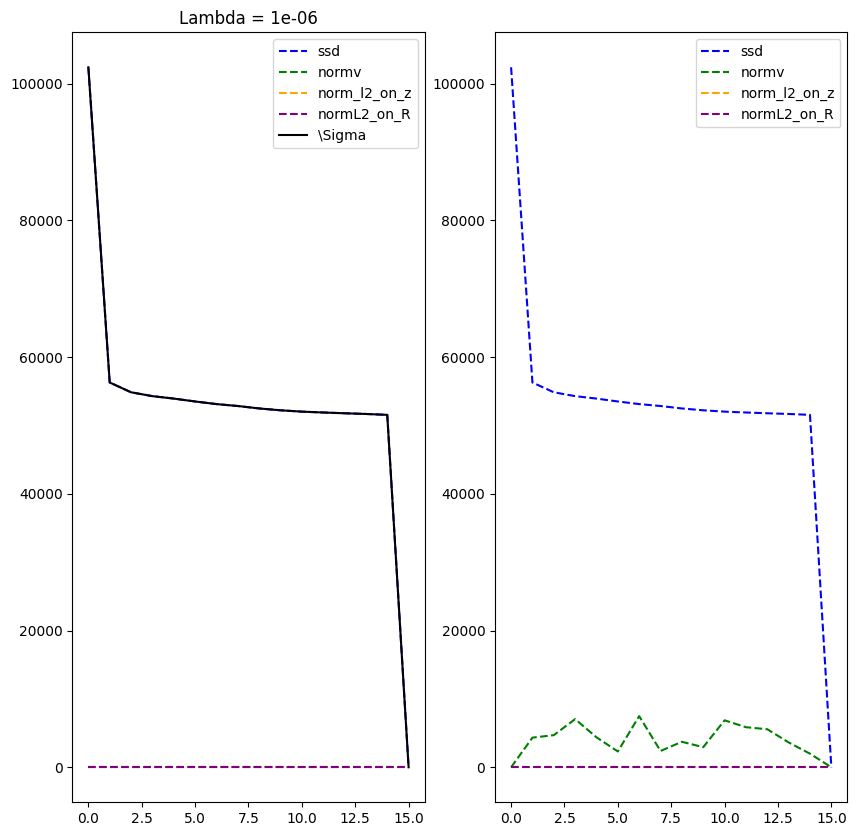

In [20]:

sigma= [3, 5, 7]
sigma = [(s,)*3 for s in sigma]
kernelOperator = rk.Multi_scale_GaussianRKHS(sigma, normalized=False)

datacost = mt.Rotation_Ssd_Cost(target_b.to("cuda:0"), alpha=.5)
# datacost = mt.Rotation_MutualInformation_Cost(target_b, alpha=.5)

momenta = mtrt.prepare_momenta(
    # mr.source.shape,
    ixi_img.shape,
    image=True,
    rotation=True,
    translation=True,
    scaling=True,
    # rot_prior=best_momentum_R.detach().clone(),trans_prior=best_momentum_T.detach().clone(),
)

for v in momenta.values():
    print(v.requires_grad)
rho = 1
try:
  mr = mt.rigid_along_metamorphosis(
      source_b, target_b, momenta_ini=momenta,
      kernelOperator= kernelOperator,
      rho = rho,
      data_term=datacost ,
      integration_steps = 10,
      cost_cst=1e-6,
      n_iter=15,
      save_gpu_memory=False,
      lbfgs_max_iter = 20,
      lbfgs_history_size = 20,
  )
except OutOfMemoryError:
  print("GPU out Out of memory! ")
  torch.cuda.empty_cache()

mr.plot_cost()


residual min -0.0 max -0.0


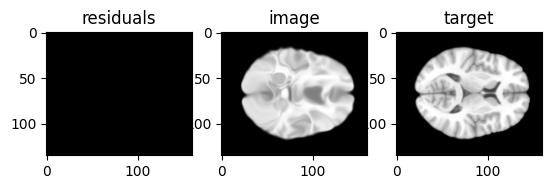

In [21]:
# fig, ax = plt.subplots(1,3)
T, _, D, H, W = ixi_img.shape
print(f"residual min {mr.mp.residuals.min()} max {mr.mp.residuals.max()}")
# Choose a central slice for plotting
slice_index = W // 2
fig, ax = plt.subplots(1,3)
ax[0].imshow(mr.mp.residuals[0,0,..., slice_index].cpu(), cmap='gray')
ax[0].set_title(f'residuals')
ax[1].imshow(mr.mp.image[0,0,..., slice_index].cpu(), cmap='gray')
ax[1].set_title(f'image')

ax[2].imshow(mr.target[0,0,..., slice_index], cmap='gray')
ax[2].set_title(f'target')
plt.show()

RigidMetamorphosis_Optimizer
flag_landmark False
tensor([0.9945, 0.9903, 0.9945]) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
torch.Size([10, 1, 135, 160, 135])


ic| axes3dsliders_plt.py:641 in _add_lines_on_plt_()
    x: 67
    y: 80
    z: 67


tensor([0.9945, 0.9903, 0.9945]) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])
btn type: <class 'matplotlib.widgets.Button'>
btn type: <class 'matplotlib.widgets.Button'>
btn type: <class 'matplotlib.widgets.Button'>
btn type: <class 'matplotlib.widgets.Button'>
module://matplotlib_inline.backend_inline

begin Toggle_image.update_display:

tensor([0.9945, 0.9903, 0.9945]) torch.Size([3]) torch.Size([1, 135, 160, 135, 3])


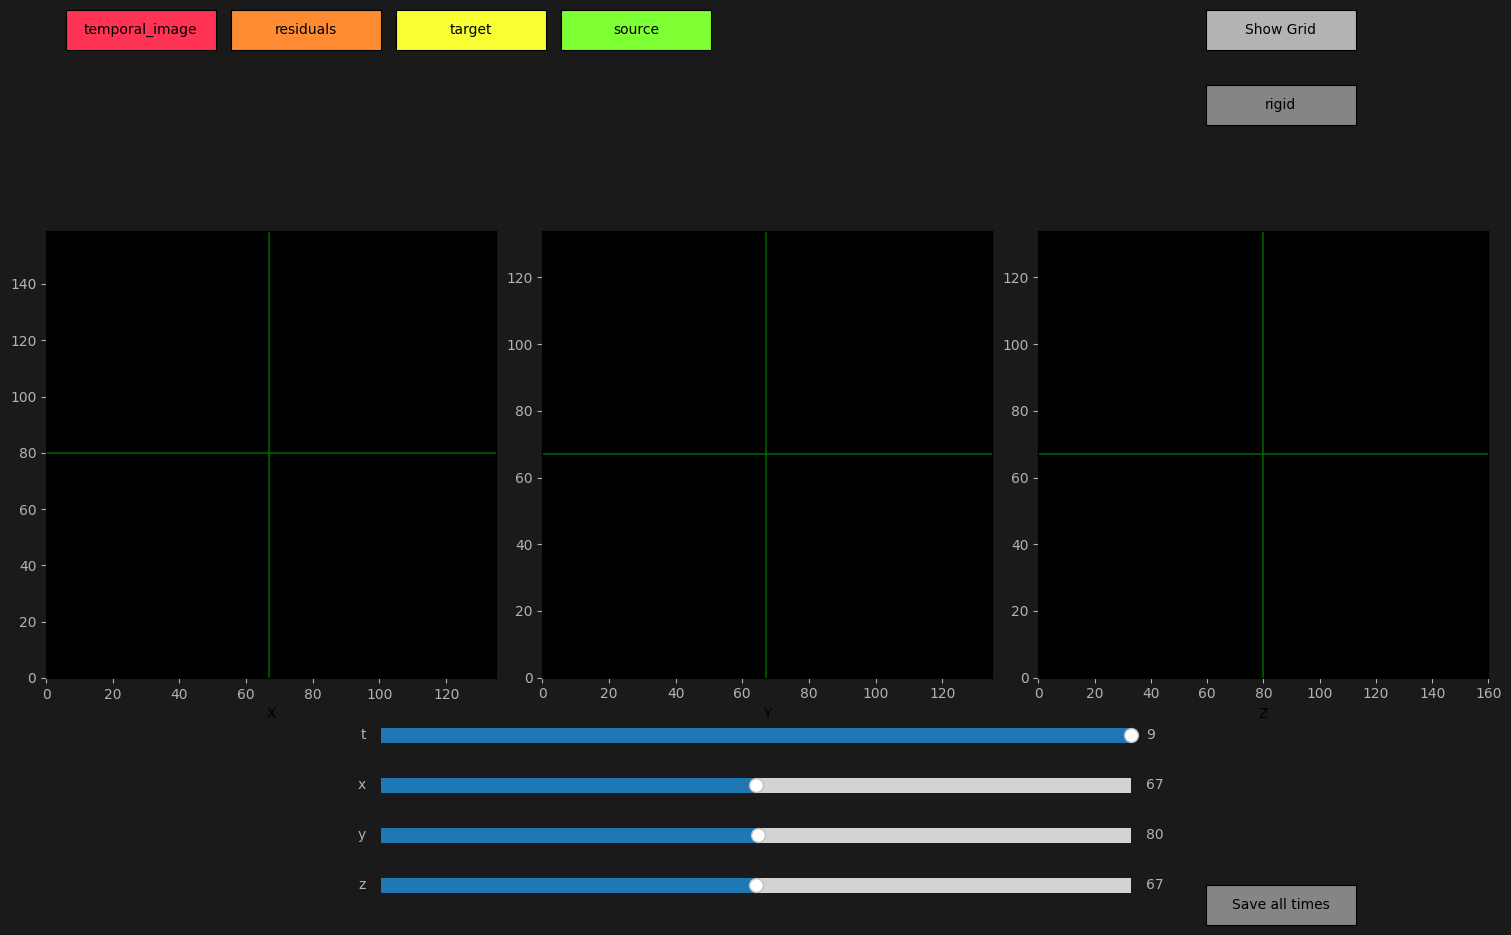

In [13]:
a3s.Visualize_GeodesicOptim_plt(mr, f"{name}_metaRigid_rho{rho}")


In [22]:
mr.save(f"{name}_ixibrain_rigidscalingLDDMM_colab",save_path="/content/drive/MyDrive/demeter_data/demeter_optim/")


ic| abstract.py:1566 in save()
    path: '/content/drive/MyDrive/demeter_data/demeter_optim/'



BUG WARNING : An other data term than Ssd was detectedFor now our method can't save it, it is ok to visualisethe optimisation, but be careful loading the optimisation.

Optimisation saved in /content/drive/MyDrive/demeter_data/demeter_optim/3D_20250730_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_root_000.pk1 



('3D_20250730_IXI002_to_template_ixibrain_rigidscalingLDDMM_colab_root_000.pk1',
 '/content/drive/MyDrive/demeter_data/demeter_optim/')